In [1]:
## Notes:
# (1) Need to verify current loss is same as desired output - still unhappy with the setup
#
# (2) There are unmerged changes on my other system, which will be a messy merge. Beware (I'll remove this message once resolved)
#
# (3) Need to double check that timestamps of different data files are aligned properly.


In [2]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


(600, 3)
(600, 6)
(600, 48, 64, 2)
Training vs. Validation sets:


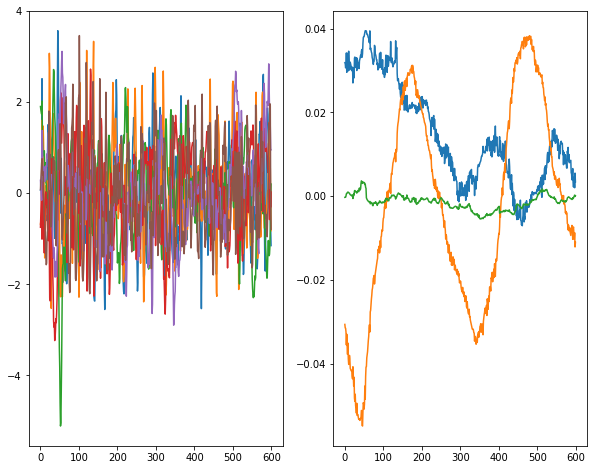

In [38]:
# Import chelsea's data
# Check times versus times.csv
# [t, x_tango, y_tango, z_tango, x_vicon, y_vicon, z_vicon, x_err_rate, y_err_rate, z_err_rate]
# Error rates, xyz
d_raw = (np.genfromtxt('trasnformed_data_slash_2.csv',delimiter=',')).astype(np.float32)
t_raw = d_raw[:,0]
t_img = (np.genfromtxt('rates.csv',delimiter=',')[:,0]).astype(np.float32)

## Align start of data streams
i_start = 0
for k in range(t_img.shape[0]):
    if(t_img[k]>t_raw[0]):
        i_start = k
        break
if i_start is 0:
    print('Warning! Time sequence alignment failed!')

# Extract and interpolate data
t_img = t_img[i_start:]
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[i_start:,1:7]).astype(np.float32)
y_data = np.array([np.interp(t_img, t_raw, d_raw[:,7]), np.interp(t_img, t_raw, d_raw[:,8]), np.interp(t_img, t_raw, d_raw[:,9])]).T

# Should really automate this... or just re-save file.
flows_data = []
flows_data.append(np.load('flows_lowres_1_16.npy'))
flows_data.append(np.load('flows_lowres_2_16.npy'))
flows_data.append(np.load('flows_lowres_3_16.npy'))
flows_data.append(np.load('flows_lowres_4_16.npy'))
flows_data.append(np.load('flows_lowres_5_16.npy'))
flows_data.append(np.load('flows_lowres_6_16.npy'))
flows_data.append(np.load('flows_lowres_7_16.npy'))
flows_data.append(np.load('flows_lowres_8_16.npy'))
flows_data.append(np.load('flows_lowres_9_16.npy'))
flows_data.append(np.load('flows_lowres_10_16.npy'))
flows_data.append(np.load('flows_lowres_11_16.npy'))
flows_data.append(np.load('flows_lowres_12_16.npy'))
flows_data.append(np.load('flows_lowres_13_16.npy'))
flows_data.append(np.load('flows_lowres_14_16.npy'))
flows_data.append(np.load('flows_lowres_15_16.npy'))
#flows_data.append(np.load('flows_lowres_16_16.npy'))
flows_data = np.concatenate(flows_data,axis=0)
flows_data = flows_data[i_start:,:,:,:]


# Shorten datastream:
i_start = 600 # remove initial weird-ness
i_end = 1200
y_data = y_data[i_start:i_end,:]
imu_data = imu_data[i_start:i_end,:]
flows_data = flows_data[i_start:i_end,:,:,:]




# Normalize imu data:
imu_data = imu_data - imu_data.mean(axis=0)
imu_data /= np.std(imu_data,axis=0)

# Normalize image data
flows_data -= flows_data.mean(axis=0)
flows_data /= np.std(flows_data,axis=0)

print(y_data.shape)
print(imu_data.shape)
print(flows_data.shape)


N_training = int(0.6*flows_data.shape[0])
N_validation = flows_data.shape[0]- N_training
training_data_indices = np.random.choice(np.arange(flows_data.shape[0]), N_training)
validation_data_indices = np.setdiff1d(np.arange(flows_data.shape[0]), training_data_indices)


# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
# These need to be randomized more - getting unwanted structure in the train/val split
def sample_minibatch(sequence_length, train=True,iseq=None):
    x_imu_batch = np.zeros((sequence_length, imu_data.shape[1]))
    x_img_batch = np.zeros((sequence_length, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
    y_batch = np.zeros((sequence_length, y_data.shape[1]))
    
    if(iseq is None):
        # randomly sample endpoint:
        # choose which subsequence to sample from: 
        if(train):
            i_stop = 0
            while i_stop - sequence_length < 0 or i_stop + sequence_length >= y_data.shape[0]:
                i_stop = training_data_indices[np.random.randint(0,N_training)]
#                i_stop = np.random.randint(0,N_training)
        else:
            i_stop = 0
            while i_stop - sequence_length < 0 or i_stop + sequence_length >= y_data.shape[0]:
#                i_stop = N_training + np.random.randint(0,N_validation)
                i_stop = validation_data_indices[np.random.randint(0,N_validation)]
    else:
        i_stop = iseq
    x_imu_batch = imu_data[i_stop-sequence_length:i_stop,:]
    y_batch = y_data[i_stop:i_stop+sequence_length,:]
    x_img_batch = flows_data[i_stop-sequence_length:i_stop,:,:,:]
    if(x_imu_batch.shape[0] == 0 or x_img_batch.shape[0]==0 or y_batch.shape[0]==0):
        print(i_stop,sequence_length)
        print(x_imu_batch.shape)
        print(x_img_batch.shape)
        print(y_batch.shape)

    return x_imu_batch, x_img_batch, y_batch, i_stop

def calc_rmse(predictions, targets):
    
    return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())

print('Training vs. Validation sets:')
plt.subplot(1,2,1)
plt.plot(imu_data)
plt.subplot(1,2,2)
plt.plot(y_data)
plt.show()

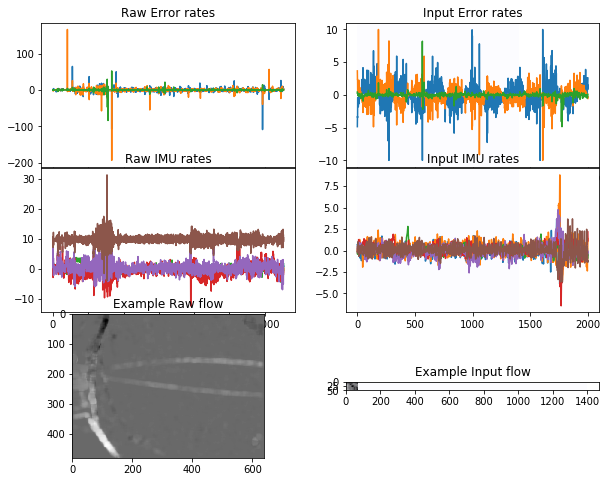

In [213]:
if False: # Legacy code now - don't run
    # Import data without time stamps
    y_raw = (np.genfromtxt('errors.csv', delimiter=',')[:,1:4]).astype(np.float32)
    y_data = np.clip(y_raw, -10.0, 10.0)
    imu_raw = (np.genfromtxt('rates.csv', delimiter=',')[:,1:7]).astype(np.float32)
    # Normalize imu data:
    imu_data = imu_raw - imu_raw.mean(axis=0)
    imu_data /= np.std(imu_data,axis=0)

    #flows_data = np.load('/media/Big_Data/stefantj/flows1.npy') # note: this only loads 1k flows, the whole flow file is huge!
    # Contains 16k images which are downsampled to 64x48
    flows_raw = np.load('/media/Big_Data/stefantj/flows1.npy')
    flows_data = np.load('/media/Big_Data/stefantj/flows_lowres_16k.npy')
    # Normalize image data
    flows_data -= flows_data.mean(axis=0)
    flows_data /= np.std(flows_data,axis=0)

    # Only train/consider first few samples:
    flows_data = flows_data[8000:10000,:,:,:];
    imu_data = imu_data[8000:10000,:]
    y_data = y_data[8000:10000,:]


    N_training = int(0.7*flows_data.shape[0])
    N_validation = flows_data.shape[0]- N_training
    training_data_indices = np.random.choice(np.arange(flows_data.shape[0]), N_training)
    validation_data_indices = np.setdiff1d(np.arange(flows_data.shape[0]), training_data_indices)
    fig = plt.gcf()
    fig.subplots_adjust(hspace=.6)

    plt.subplot(3,2,1)
    plt.title('Raw Error rates')
    plt.plot(y_raw)
    plt.subplot(3,2,3)
    plt.title('Raw IMU rates')
    plt.plot(imu_raw)
    plt.subplot(3,2,5)
    plt.title('Example Raw flow')
    i = np.random.randint(0,flows_raw.shape[0])
    plt.imshow(flows_raw[i,:,:,1])

    plt.subplot(3,2,2)
    plt.title('Input Error rates')
    plt.plot(y_data)
    plt.axvspan(0,N_training, facecolor='b',alpha=0.01)
    plt.subplot(3,2,4)
    plt.title('Input IMU rates')
    plt.plot(imu_data)
    plt.axvspan(0,N_training, facecolor='b',alpha=0.01)
    fig = plt.gcf()
    fig.subplots_adjust(hspace=.01)
    plt.subplot(3,2,6)
    plt.title('Example Input flow')
    plt.imshow(flows_data[i,:,:,1])
    plt.axvspan(0,N_training, facecolor='b',alpha=0.01)

    # sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
    # These need to be randomized more - getting unwanted structure in the train/val split
    def sample_minibatch(sequence_length, train=True,iseq=None):
        x_imu_batch = np.zeros((sequence_length, imu_data.shape[1]))
        x_img_batch = np.zeros((sequence_length, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
        y_batch = np.zeros((sequence_length, y_data.shape[1]))

        if(iseq is None):
            # randomly sample endpoint:
            # choose which subsequence to sample from: 
            if(train):
                i_stop = 0
                while i_stop - sequence_length < 0:
    #                i_stop = training_data_indices[np.random.randint(0,N_training)]
                    i_stop = np.random.randint(0,N_training)
            else:
                i_stop = 0
                while i_stop - sequence_length < 0:
                    i_stop = N_training + np.random.randint(0,N_validation)
    #                i_stop = validation_data_indices[np.random.randint(0,N_validation)]
        else:
            i_stop = iseq
        x_imu_batch = imu_data[i_stop-sequence_length:i_stop,:]
        y_batch = y_data[i_stop-sequence_length:i_stop,:]
        x_img_batch = flows_data[i_stop-sequence_length:i_stop,:,:,:]
        if(x_imu_batch.shape[0] == 0 or x_img_batch.shape[0]==0):
            print(i_stop,sequence_length)

        return x_imu_batch, x_img_batch, y_batch, i_stop

    def calc_rmse(predictions, targets):

        return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())


<function matplotlib.pyplot.show>

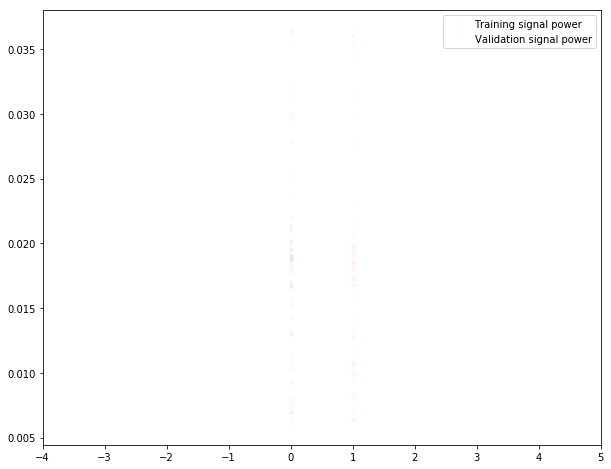

In [40]:
# Check that the signal is relatively evenly distributed between train/val
val_dist = []
train_dist = []
n_samp = 100
for k in range(n_samp):
    x,x2,y,i = sample_minibatch(4);
    err = calc_rmse(np.zeros_like(y),y);
    train_dist.append(err)
    
    x,x2,y,i = sample_minibatch(4,False);
    err = calc_rmse(np.zeros_like(y),y);
    val_dist.append(err)


plt.plot(np.zeros(n_samp), train_dist,'.',alpha=0.01)
plt.plot(np.ones(n_samp), val_dist,'.',alpha=0.01)
plt.xlim([-4,5])
plt.legend(['Training signal power', 'Validation signal power'])
plt.show

In [41]:
# Definition of network:
# rescale the images ~ 64x48
# Try normalizing 
# feed output back in
# see if you can get cats roughly hte same size

OUTPUT_DIM = 3
BATCH_SIZE = 4
#SUB_BATCH_SIZE = 30
R_HISTORY = 32    # length of the time series
IMG_H = 48
IMG_W = 64

sub_batches = R_HISTORY*np.ones(BATCH_SIZE)

class tangoNet(object):

    # Extract features for a single time step
    def extract_features(self, input_img=None, input_imu=None, reuse=True):
        if input_img is None:
            input_img = self.image  # will need to split this into input1, input2
        if input_imu is None:
            input_imu = self.imu
        x = input_img
        x_r = input_imu
        
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('cnn_1'):
                # 64 filters of size 5 <- needs to be tuned!
                x = tf.layers.conv2d(x, 64, 3, strides=2, activation=tf.nn.relu, padding='valid')
                layers.append(x)
            with tf.variable_scope('cnn_2'):
                x = tf.nn.max_pool(x, [1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
#            with tf.variable_scope('cnn_3'):
                # 64 filters of size 5 <- needs to be tuned!
#                x = tf.layers.conv2d(x, 64, 3, strides=2, activation=tf.nn.relu, padding='valid')
#                layers.append(x)
#            with tf.variable_scope('cnn_4'):
#                x = tf.nn.max_pool(x, [1,3,3,1],strides=[1,2,2,1],padding='VALID')
#                layers.append(x)
#            with tf.variable_scope('cnn_5'):
#                x = tf.layers.dense(x, 32, activation=tf.nn.relu)
#                layers.append(x)
            with tf.variable_scope('dense_1'):
                x_r = tf.layers.dense(x_r, 32, activation=tf.nn.relu)
                layers.append(x_r)
            with tf.variable_scope('concat1'):
                # reshape: 
                x = tf.reshape(x, [BATCH_SIZE,-1])
                x_r = tf.reshape(x_r, [BATCH_SIZE,-1])
                x = tf.concat([x,x_r],1)
                layers.append(x)
            return layers

    def __init__(self, batch_size, save_path=None, sess=None):
        self.batch_size = tf.constant(batch_size,dtype=tf.int32)
        # r_depth, batch, width, height, channels
        self.image = tf.placeholder('float',shape=[R_HISTORY*batch_size,IMG_H,IMG_W,2],name='input_image_seq')
        # r_depth, batch, input_dim
        self.imu   = tf.placeholder('float',shape=[R_HISTORY*batch_size,6],name='input_imu_seq')
        # batch, output_dim
        self.errs  = tf.placeholder('float',shape=[R_HISTORY*batch_size, OUTPUT_DIM],name='output_error')
        self.lr = tf.placeholder('float',shape=[1],name='lr')

        self.layers = []
        self.features = []
        for k in range(R_HISTORY):
            img = self.image[batch_size*k:batch_size*(k+1),:,:,:]
            imu = self.imu[batch_size*k:batch_size*(k+1),:]
            r = (k!=0)
            self.features.append(self.extract_features(img, imu, reuse=r)[-1])
        
        with tf.variable_scope('core_lstm'):
            with tf.variable_scope('core_0'):
                x_r = self.features
                self.layers.append(x_r)
            with tf.variable_scope('core_1'):
                lstm_cell = tf.contrib.rnn.BasicLSTMCell(256)
                x_r, states = tf.contrib.rnn.static_rnn(lstm_cell, x_r, dtype=tf.float32, sequence_length=sub_batches)
                self.layers.append(x_r[-1])
            with tf.variable_scope('core_2'):
                W = tf.get_variable("weights", shape=[256,OUTPUT_DIM])
                b = tf.get_variable("bias", shape=[OUTPUT_DIM])
                x_r = tf.concat(x_r, axis=0)
                x_r = tf.matmul(x_r, W) + b
                self.layers.append(x_r)
        self.prediction = tf.reshape(x_r, [-1, OUTPUT_DIM])

        if save_path is not None:
            saver = tf.train.Saver()
            saver.restore(sess, save_path)
        # Needs a bit of work still
#        self.rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(self.errs[-1,:], self.prediction[-1,:])))
        self.rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(self.errs[0], self.prediction[-1])))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr[0]).minimize(self.rmse)


Step:  100  MSE:  0.0290002  Val:  0.0975631 Naive:  0.0166761216816 LR:  0.004851495


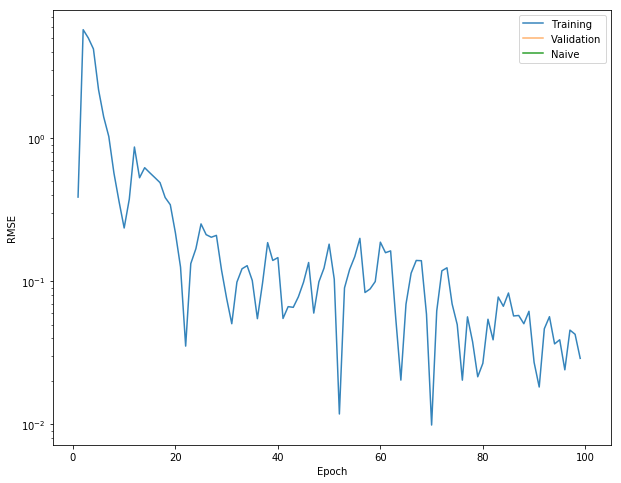

Step:  200  MSE:  0.0411674  Val:  0.0391744 Naive:  0.0166761216816 LR:  0.004707400747005


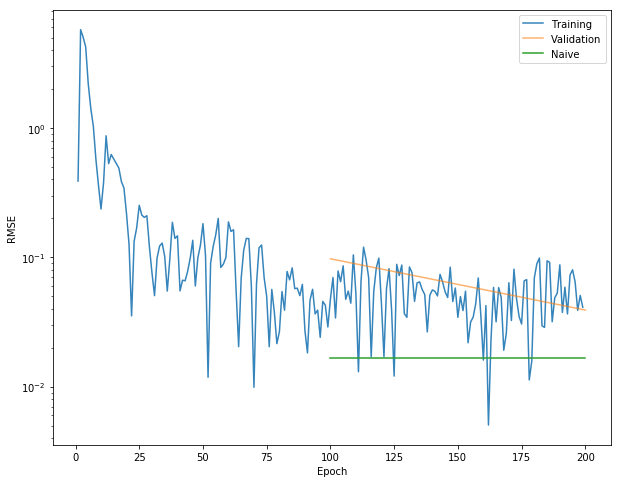

Step:  300  MSE:  0.0394324  Val:  0.0394097 Naive:  0.0166761216816 LR:  0.004567586237418204


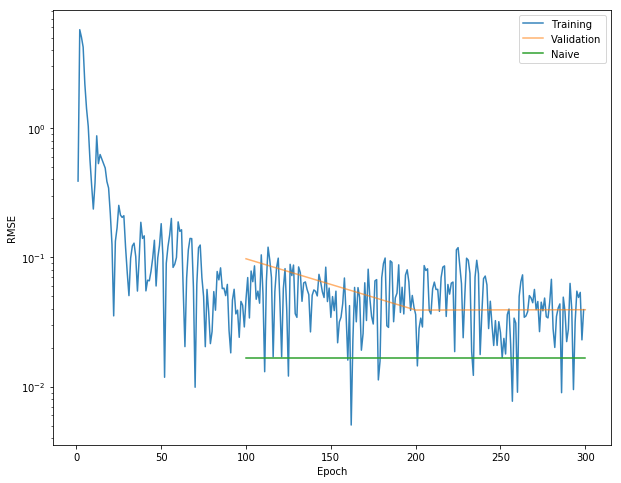

Step:  400  MSE:  0.0559559  Val:  0.0172588 Naive:  0.0166761216816 LR:  0.00438760511499484


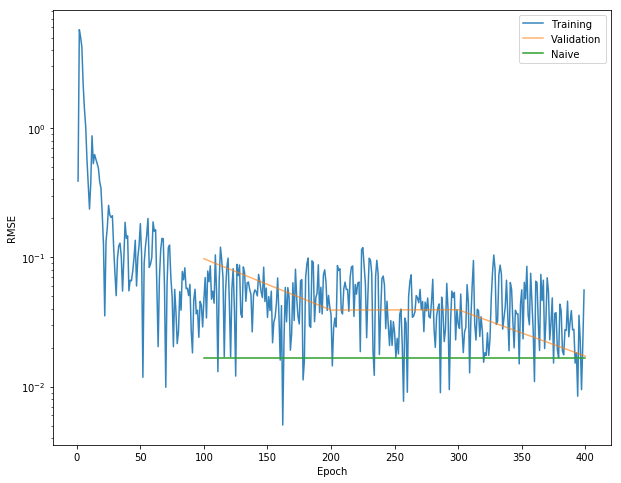

Step:  500  MSE:  0.0485697  Val:  0.0689295 Naive:  0.0166761216816 LR:  0.0042572888554743785


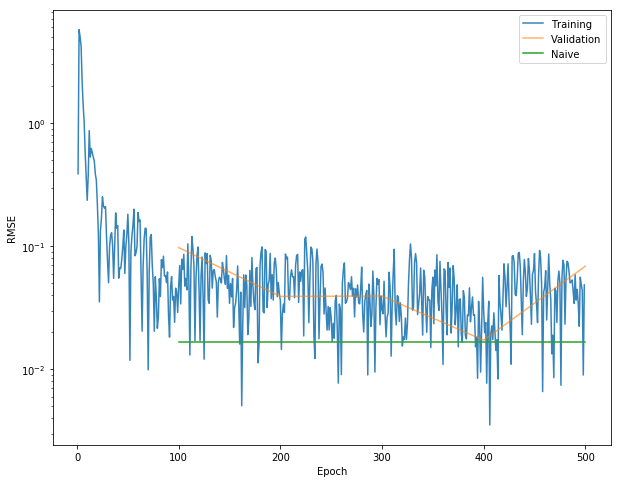

Step:  600  MSE:  0.0323163  Val:  0.032983 Naive:  0.0166761216816 LR:  0.0041308431191779335


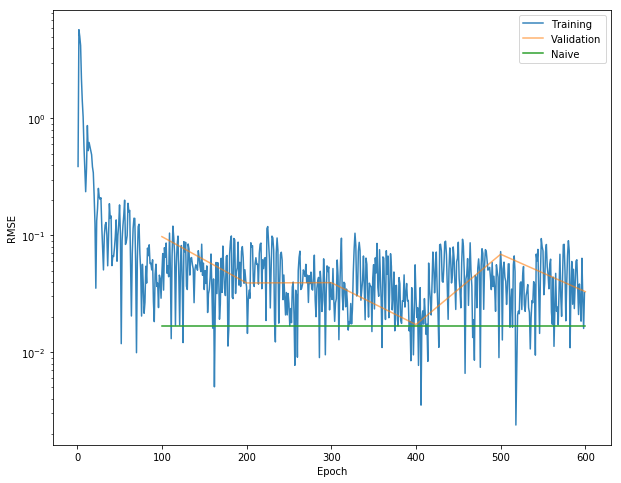

Step:  700  MSE:  0.0231413  Val:  0.0470432 Naive:  0.0166761216816 LR:  0.003968071418218277


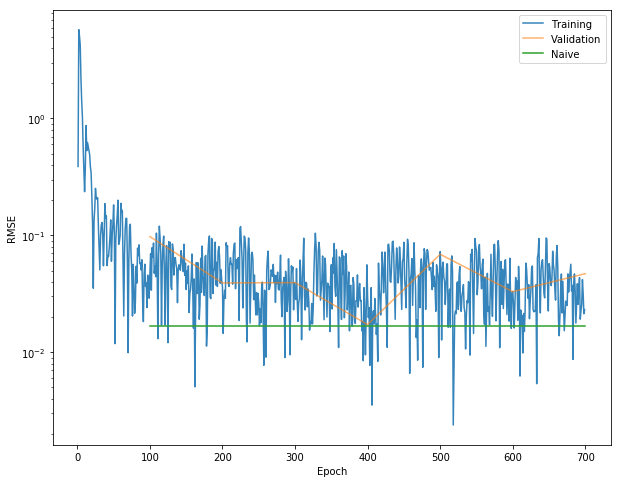

Step:  800  MSE:  0.0313579  Val:  0.0516622 Naive:  0.0166761216816 LR:  0.003850215729025776


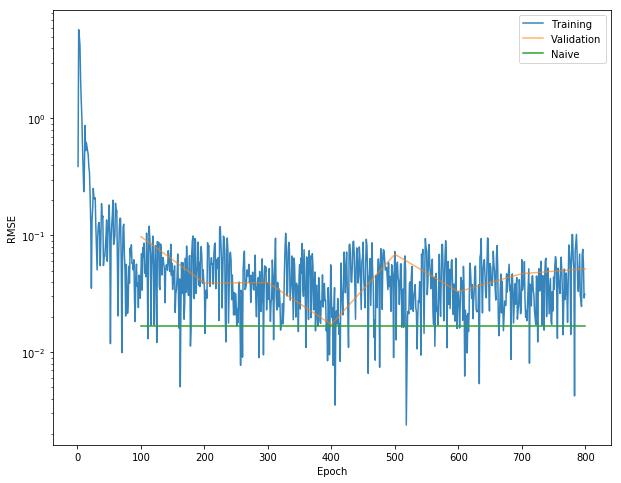

Step:  900  MSE:  0.0176233  Val:  0.0346286 Naive:  0.0166761216816 LR:  0.0037358604716579815


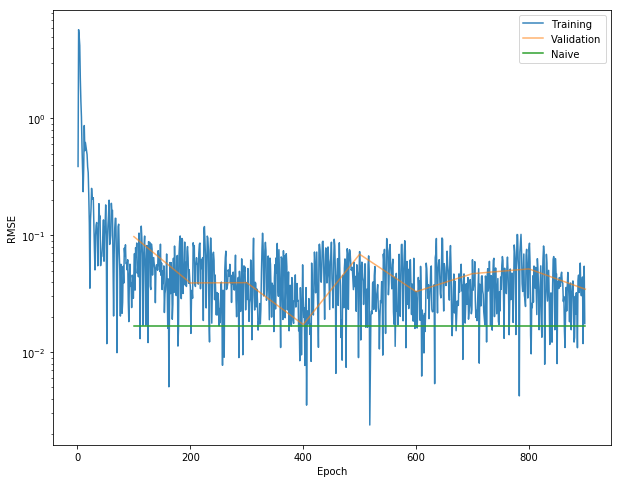

Step:  1000  MSE:  0.0271371  Val:  0.0438922 Naive:  0.0166761216816 LR:  0.0035886526629913752


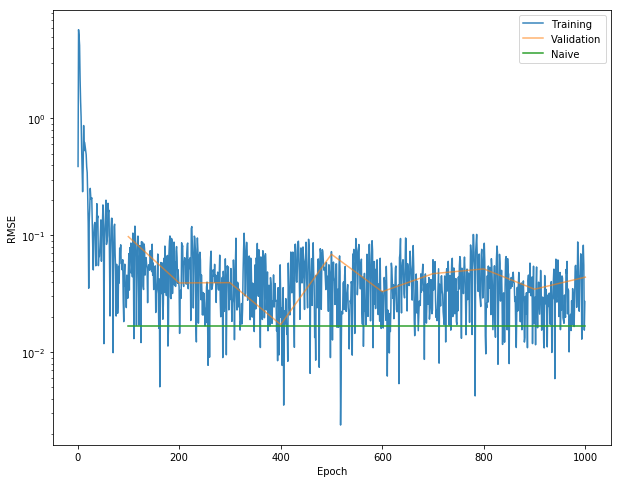

Step:  1100  MSE:  0.0418886  Val:  0.0277278 Naive:  0.0166761216816 LR:  0.0034820660902478684


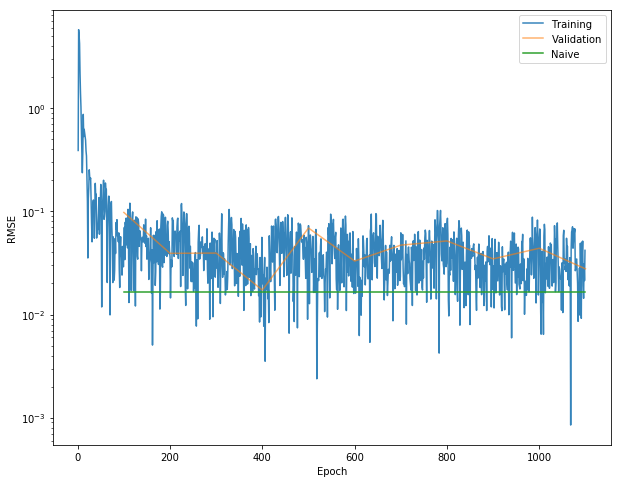

Step:  1200  MSE:  0.0444455  Val:  0.0764352 Naive:  0.0166761216816 LR:  0.0033786452453014168


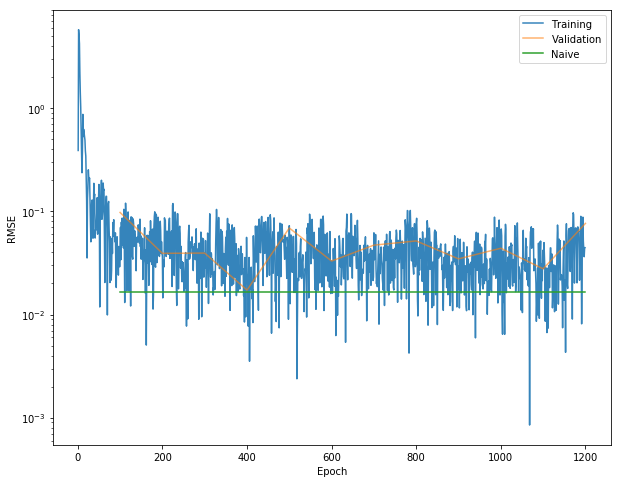

Step:  1300  MSE:  0.0160034  Val:  0.0192385 Naive:  0.0166761216816 LR:  0.0032455131418420114


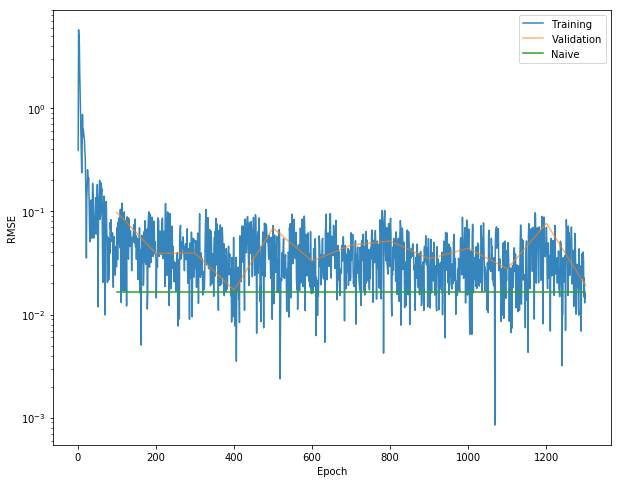

Step:  1400  MSE:  0.0512014  Val:  0.0500794 Naive:  0.0166761216816 LR:  0.0031491181560161616


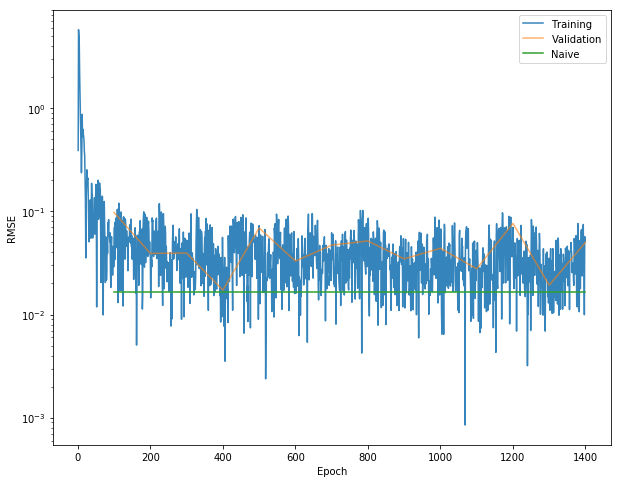

In [ ]:
# simple parameters:
disp_period = 100
training_iters = 10000
lr = 0.005
lr_decay=0.99

with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = '/media/Big_Data/stefantj/tangonet.ckpt'

    model = tangoNet(batch_size = BATCH_SIZE, sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []
    naive_history = []
    naive_val = 0
    for k in range(y_data.shape[0]):
        naive_val += calc_rmse(y_data[k,:],np.zeros(OUTPUT_DIM))
    naive_val /= y_data.shape[0]

    # Launch the graph
    sess.run(init)
    step = 1
    ind_train = []
    train_inds = []
    val_inds = []
    # Keep training until reach max iterations
    while step  < training_iters:
        if step % 30 is 0:
            lr *= lr_decay
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x1, batch_x2, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE)
        ind_train.append([istp-R_HISTORY*BATCH_SIZE, istp])
        
        # Run optimization op (backprop)
        o,mse = sess.run([model.optimizer,model.rmse], feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y, model.lr:[lr]})
        train_inds.append(step)
        train_history.append(mse)
        
        step += 1
        if step % disp_period is 0:
            # Calculate batch accuracy
#            mse,pred = sess.run([model.rmse, model.prediction], feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
#            train_history.append(mse)
    #        if(np.abs(mse-calc_rmse(pred, batch_y)) > 0.001):
    #            print('MSE Discrepancy: ', mse, ' vs. ', calc_rmse(pred, batch_y))
            naive_history.append(naive_val)
            # Calculate val accuracy:
            batch_x1, batch_x2, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, False)
            vmse = sess.run(model.rmse, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
            val_history.append(vmse)
            val_inds.append(step)
            
            print('Step: ', step, ' MSE: ', mse, ' Val: ', vmse, 'Naive: ', naive_val,'LR: ', lr)
            plt.semilogy(train_inds, train_history,alpha=0.9)
            plt.semilogy(val_inds, val_history,alpha=0.6)
            plt.semilogy(val_inds, naive_history)
            plt.legend(['Training','Validation','Naive'])
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.show()
    # Compute sequence prediction:
    print('Computing sequence prediction - this may take a while. ')
    y_pred = np.zeros((y_data.shape[0], y_data.shape[1]))
    for k in range(BATCH_SIZE*R_HISTORY, flows_data.shape[0]):
        if k % 1000 is 0:
            print('k = ', k)
        batch_x1, batch_x2, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, k)
        pred = sess.run(model.prediction, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        y_pred[k,:] = pred[-1]
    np.save('prediction', y_pred)
print('Done.')


In [ ]:
# Can load a previously computed prediction - useful if cold starting a notebook.
print('Loading data...')
y_pred = np.load('prediction.npy')

# Blue background corresponds to data used during training
def plot_data(ns, ne):
    
    print('plotting from ', ns, ' to ', ne)
    for k in range(3):
        plt.subplot(2,3,k+1)
        plt.ylabel('Error Rate')
        plt.plot(y_pred[ns:ne,k],'.',alpha=0.3)
        plt.plot(y_data[ns:ne,k],'.',alpha=0.6)
#        plt.axvspan(0,N_training, facecolor='b',alpha=0.1)
        plt.legend(['Predicted','Actual'])

        plt.subplot(2,3,k+4)
        plt.ylabel('Cumulative Error')
        plt.plot(np.cumsum(y_pred[ns:ne,k]))
        plt.plot(np.cumsum(y_data[ns:ne,k]))
#        plt.axvspan(0,N_training, facecolor='b',alpha=0.1)
        plt.legend(['Predicted','Actual'])
    plt.show()

def plot_error(ns, ne):
    
    print('High correlation (near 1) means we are predicting noise.')
    for k in range(3):
        c1 = np.sqrt(np.correlate(y_data[ns:ne,k],y_data[ns:ne,k])[0])
        c2 = np.sqrt(np.correlate(y_pred[ns:ne,k]-y_data[ns:ne,k],y_pred[ns:ne,k]-y_data[ns:ne,k])[0])
        c12 = (np.correlate(y_data[ns:ne,k],y_pred[ns:ne,k]-y_data[ns:ne,k]))[0]/(c1*c2)
        print('Dim. ', k, ': Correlation between error and signal:', (np.abs(c12)))

        plt.subplot(2,3,k+1)
        plt.ylabel('Prediction Errors')
        plt.plot(y_pred[ns:ne,k]-y_data[ns:ne,k])
        plt.plot(-y_data[ns:ne,k],':')
        plt.legend(['Error', 'Signal'])

        # uninteresting 1d plot
#        plt.subplot(2,3,k+4)
#        plt.ylabel('Correlation')
#        plt.plot(c2,alpha=0.5)
#        plt.plot(c1,':',alpha=0.3)
    plt.show()


#plt.title('Learning Curve')
#naive_val = 0
#for k in range(y_data.shape[0]):
#    naive_val += calc_rmse(y_data[k,:],np.zeros(OUTPUT_DIM))
#naive_val /= y_data.shape[0]

#plt.plot(train_history,'.',alpha=0.3)
#plt.plot(val_history,'.',alpha=0.3)
#plt.plot(naive_val*np.ones_like(train_history),':')
#plt.legend(['Training','Validation','Naive'])
#plt.xlabel('Epoch')
#plt.ylabel('RMSE')
#plt.show()


plot_data(0,1000)
plot_error(0,1000)

plot_data(5000,5300)
plot_error(5000,5300)

NameError: name 'ne' is not defined

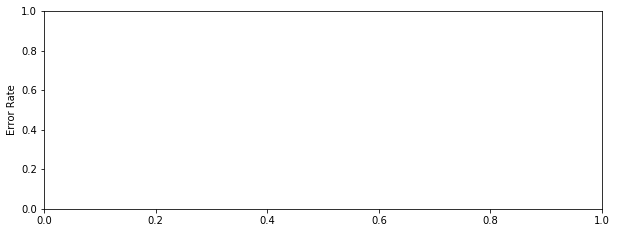

In [125]:
ns = 2000
nt = 3500
k=0
plt.subplot(2,1,1)
plt.ylabel('Error Rate')
plt.plot(y_pred[ns:ne,k],'.',alpha=0.3)
plt.plot(y_data[ns:ne,k],'.',alpha=0.6)
plt.legend(['Predicted','Actual'])

plt.subplot(2,1,2)
plt.ylabel('Cumulative Error')
plt.plot(np.cumsum(y_pred[ns:ne,k]))
plt.plot(np.cumsum(y_data[ns:ne,k]))
plt.legend(['Predicted','Actual'])

plt.show()



700
1.36082859449
1.36905436092
1.00136670138


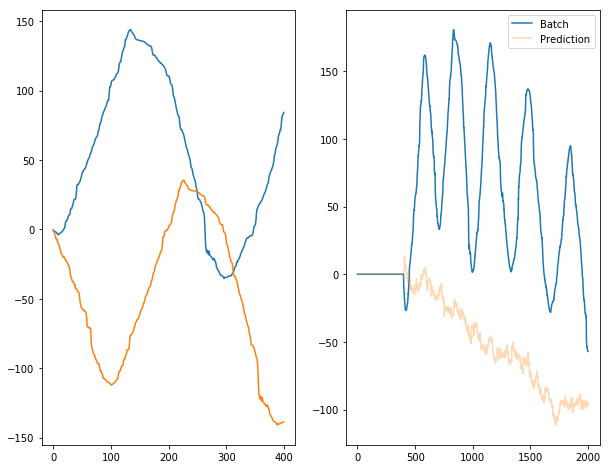

700 134 226 -92


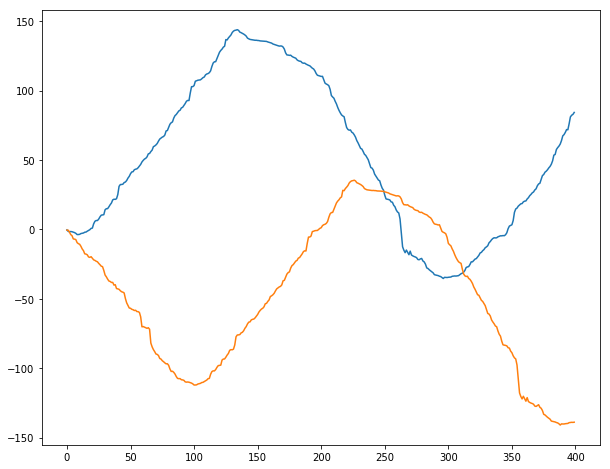

701 133 279 -146


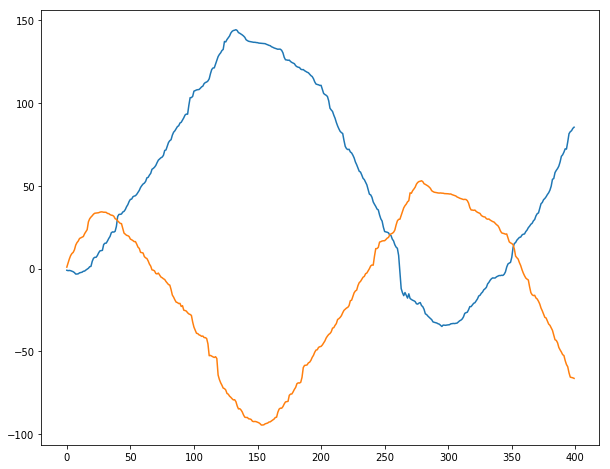

702 132 48 84


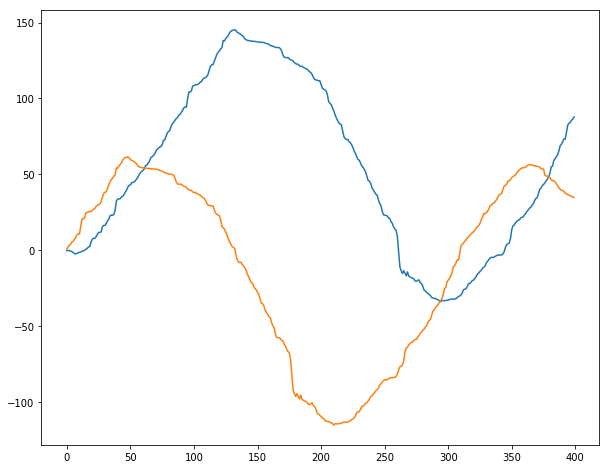

703 131 181 -50


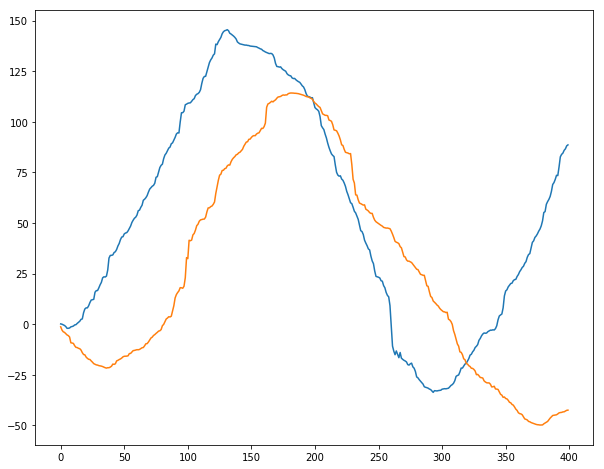

704 130 50 80


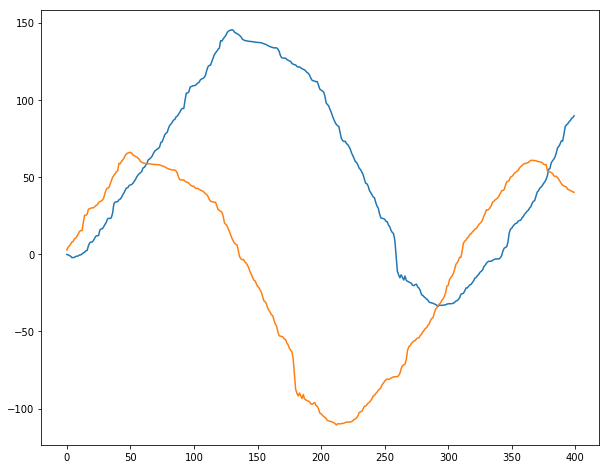

705 129 167 -38


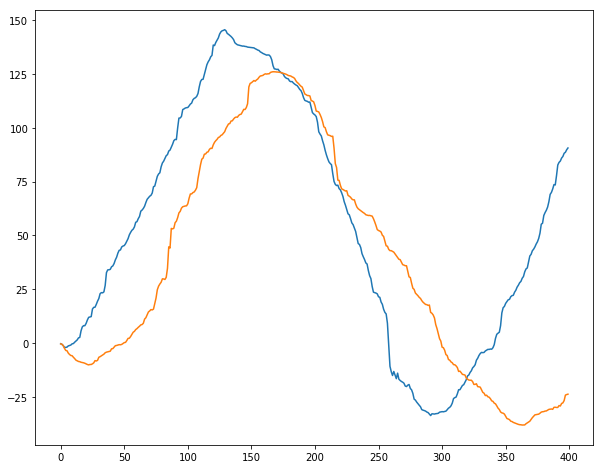

706 128 115 13


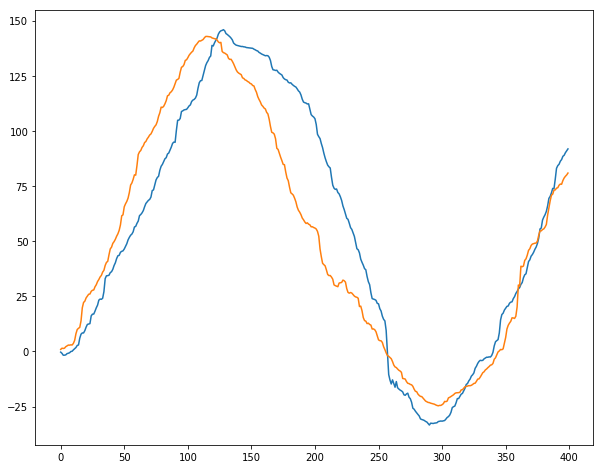

707 127 30 97


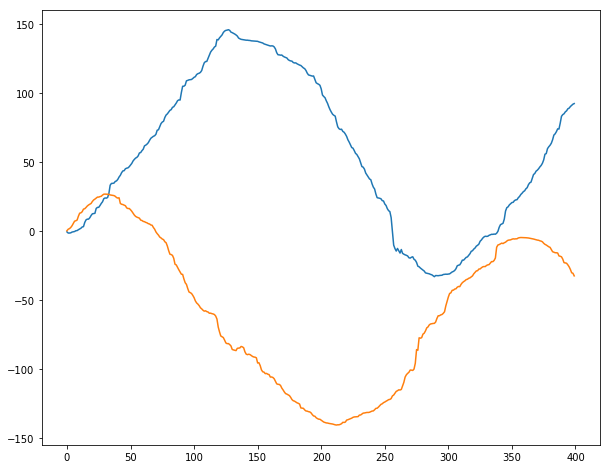

708 126 162 -36


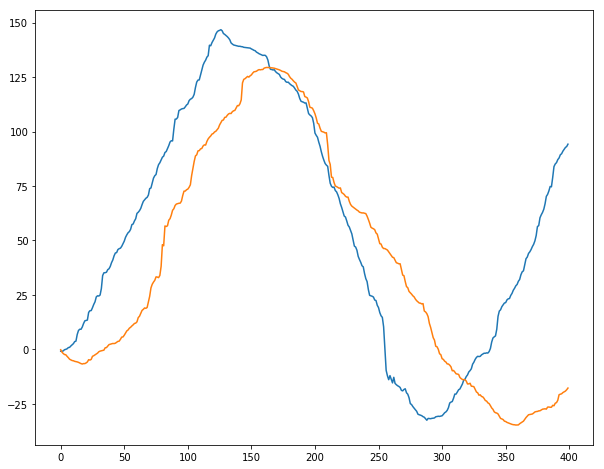

709 125 129 -4


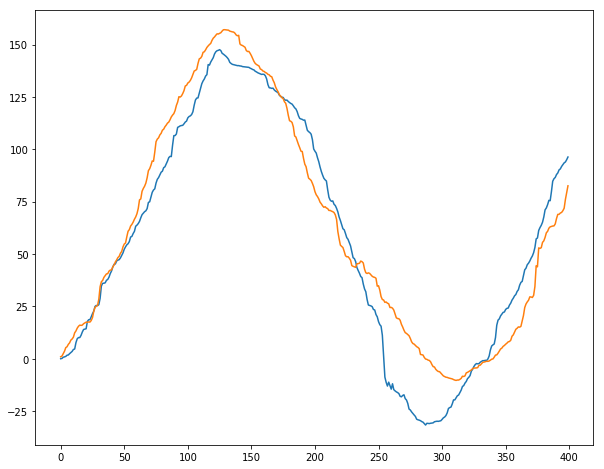

710 124 218 -94


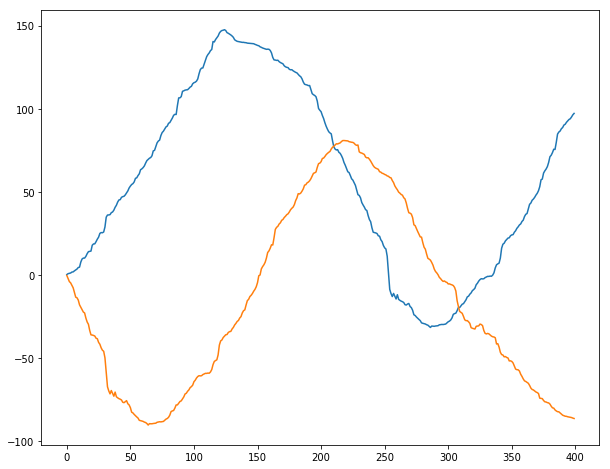

711 123 116 7


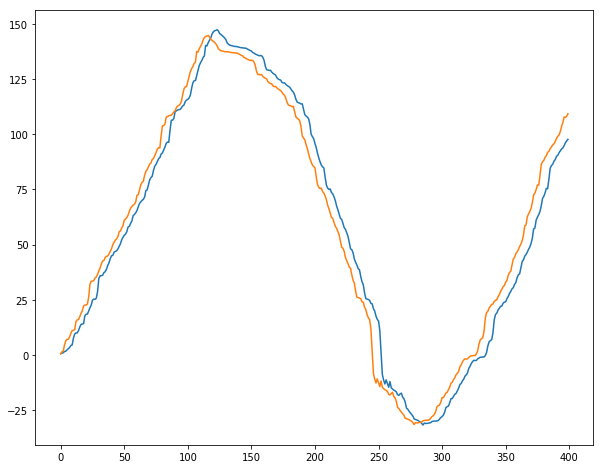

712 122 47 75


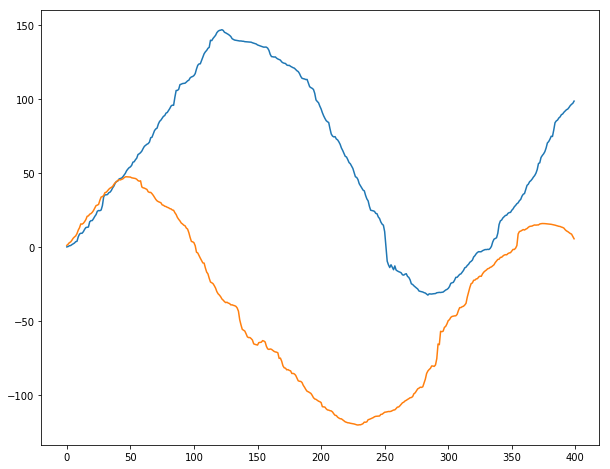

713 121 347 -226


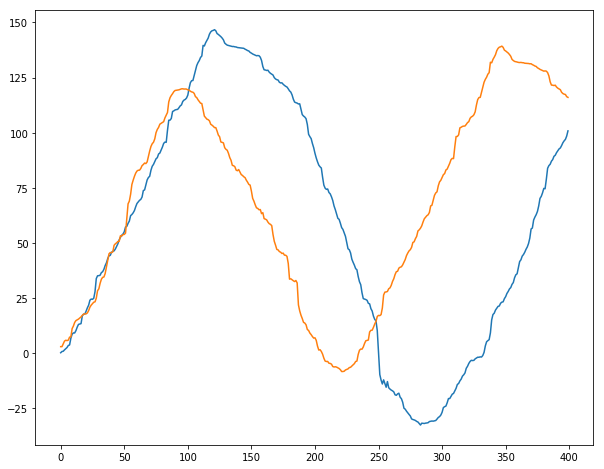

714 120 163 -43


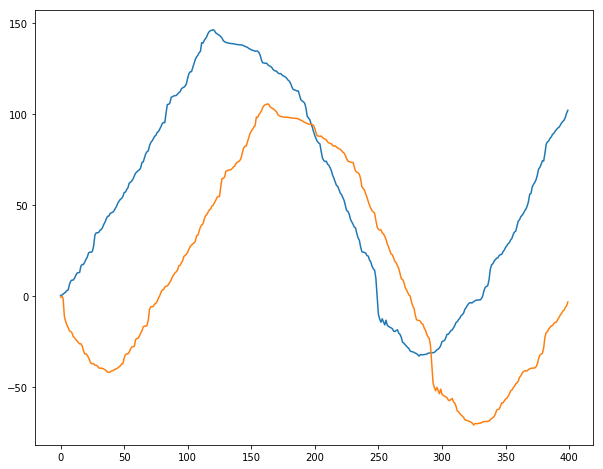

715 119 112 7


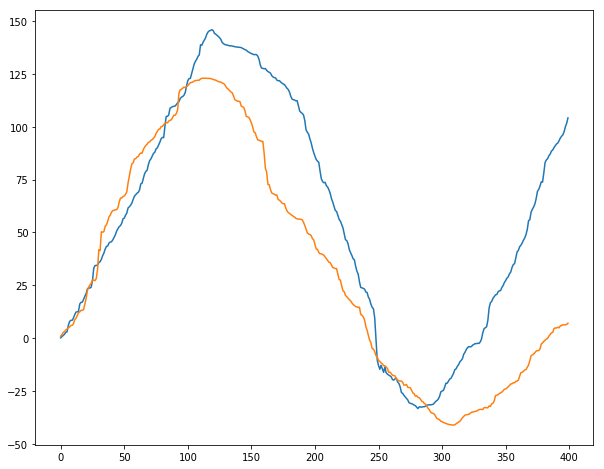

716 118 182 -64


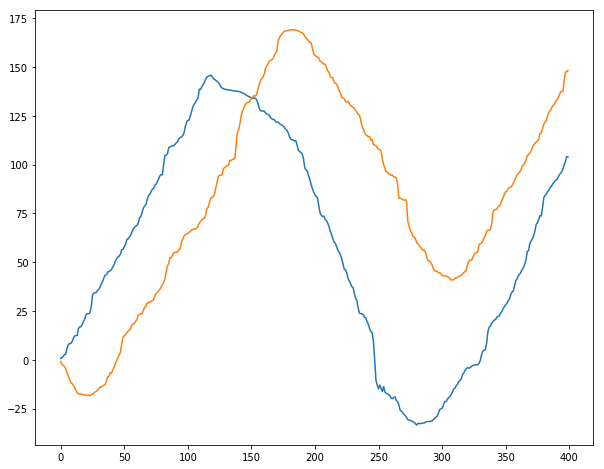

717 117 76 41


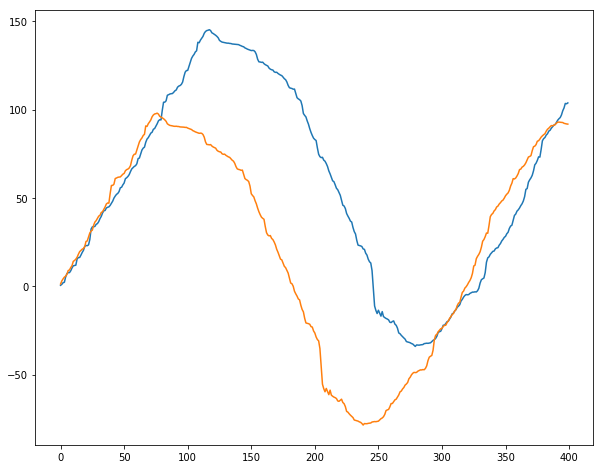

718 116 232 -116


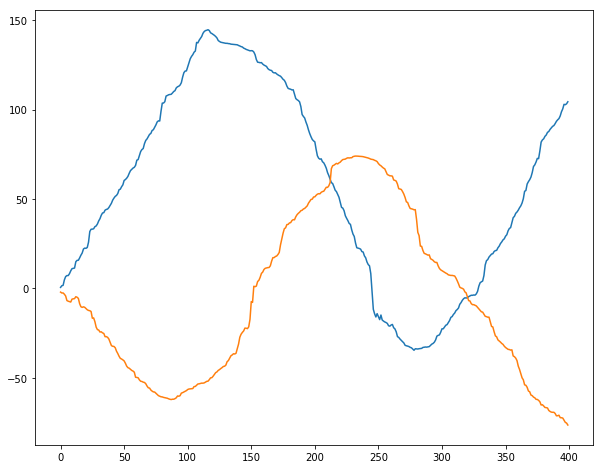

719 115 207 -92


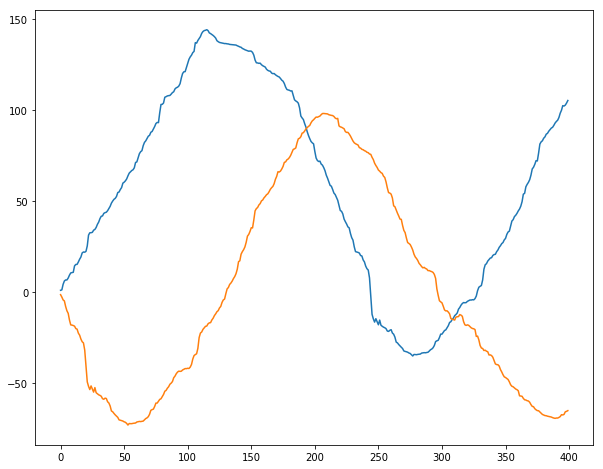

2.60297346735
1.67255


In [208]:

k=700
batch_x1, batch_x2, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, True, k)
print(istp)
dim=0
xoff=399
xvals = np.arange(0,400-xoff);
truth = batch_y[:,dim]#y_data[:,0]
predict_f = (y_pred[k,xoff:,dim])
predict = (y_pred[k,:,dim])

t = np.zeros((2000,3))
t_end = np.zeros((2000,3))
p = np.zeros((2000,3))
for kk  in range(400,2000):
    batch_x1, batch_x2, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, True, kk)
    t[kk,:] = batch_y[0,:]
    t_end[kk,:] = batch_y[-1,:]
    p[kk,:] = y_pred[kk,-1,:]

print(calc_rmse(t,p))
print(calc_rmse(t_end,p))
print(calc_rmse(t, np.zeros_like(t)))
#truth = y_data[:,dim]
#predict = y_pred[:,2,dim]

plt.subplot(1,2,1)
plt.plot(np.cumsum(truth))
plt.plot(np.cumsum(predict))
plt.subplot(1,2,2)
plt.plot(np.cumsum(t[:,0]))
plt.plot(np.cumsum(p[:,0]),alpha=0.3)
plt.legend(['Batch','Prediction'])
plt.show()

for k in range(700,720):
    batch_x1, batch_x2, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, True, k)
    xvals = np.arange(0,400);
    plt.plot(xvals, np.cumsum(batch_y[:,dim]))
    plt.plot(xvals, np.cumsum(y_pred[k,:,dim]))
    i1 = np.argmax(np.cumsum(batch_y[:,dim]))
    i2 = np.argmax(np.cumsum(y_pred[k,:,dim]))
    print(k,i1,i2, i1-i2)
    plt.show()

print(calc_rmse(truth, predict))
print(calc_rmse(truth, np.zeros_like(truth)))


#rmses = np.zeros(400)
#rmse_naive = np.zeros(400)
#for k in range(400):
#    print('Offset: ', k)
#    for kk in range(400,2000):
#        batch_x1, batch_x2, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE,True, kk)
#        print(batch_y[k:,dim].shape)
#        print(y_pred[istp,k:,dim].shape)
#        rmses[k] += calc_rmse(batch_y[:400-k,dim], y_pred[istp,k:,dim])/2000.0;
#        rmse_naive[k] += calc_rmse(y_data[:,dim],np.zeros_like(y_data[:,dim]))/2000.0
    
#plt.plot(rmses)
#plt.plot(rmse_naive)



(0, 2)

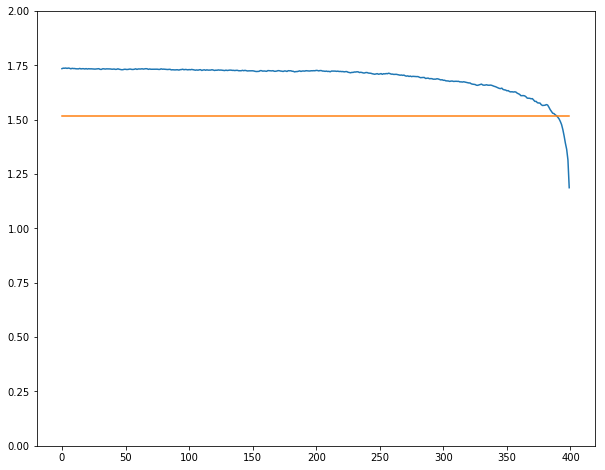

In [177]:
rmse_naive = calc_rmse(y_data[:,dim],np.zeros_like(y_data[:,dim]))*np.ones(400)
plt.plot(rmses)
plt.plot(rmse_naive)
plt.ylim([0,2])

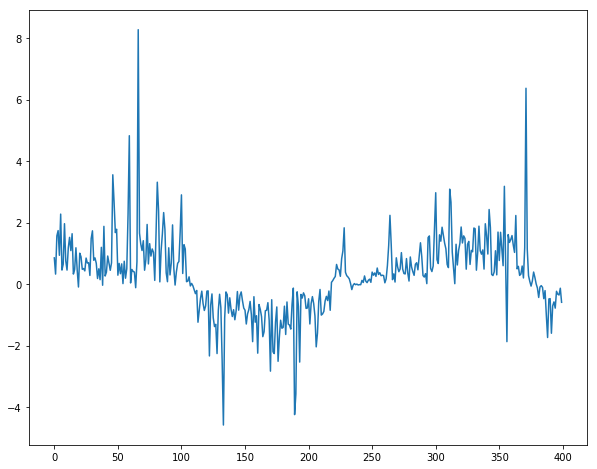

In [192]:
plt.plot(y_pred[k,:,1])